In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import ephem

In [2]:
#m180to0 = np.load("m180to0x.npy")
#p0to180 = np.load("0to180x.npy")
#arr=np.concatenate([m180to0, p0to180])
#ds = xr.DataArray(arr, dims=["azimuth", "x", "y"]).to_netcdf("hangle.nc")

In [3]:
ds = xr.open_dataset("hangle.nc")

In [4]:
ds=ds.rename({"__xarray_dataarray_variable__":"hangle"})

In [5]:
#ds.hangle.values[:,:,:] = ds.hangle.values[:,::-1,:]

In [6]:
dem_main = xr.open_dataset("/Users/william/Documents/datasets/GeographicData/DEMS/dsm_mosaic_clipped.nc").Band1

In [7]:
dem_main_coarsen = dem_main.coarsen(x=5, y=5, boundary="trim").mean()

In [8]:
ds = ds.rename({"y":"x", "x":"y"})


In [9]:
ds = ds.assign_coords(azimuth=np.linspace(-180, 180, 200), x=dem_main_coarsen.x, y=dem_main_coarsen.y)
#ds = ds.assign_coords(azimuth=np.linspace(360, 0, 200), x=dem_main_coarsen.x, y=dem_main_coarsen.y)


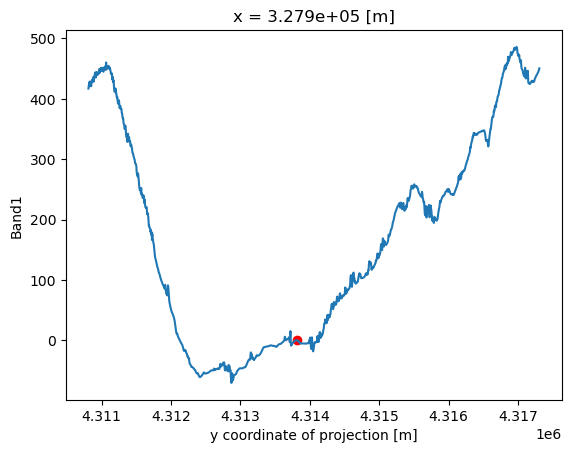

In [10]:
xl = 327889.75427288306
yl = 4313811.21370096
hgt_val = dem_main_coarsen.sel(x=xl, y=yl, method="nearest")
#(dem_main_coarsen.sel(x = slice(xl - 500, xl+500), y=slice(yl-1,yl+1)) - hgt_val).plot()
(dem_main_coarsen.sel(x = slice(xl - 1, xl+1), y=slice(yl-3000,yl+3500)) - hgt_val).plot()
plt.scatter(yl, 0, color="red")


In [11]:
dzx = (dem_main_coarsen.sel(x = slice(xl - 3500, xl+3500), y=slice(yl-1,yl+1)) - hgt_val)
dx = dzx.x - hgt_val.x
hangle_x = np.sin(np.arctan2(dzx, dx))

In [12]:
dzy = (dem_main_coarsen.sel(x = slice(xl - 1, xl+1), y=slice(yl-3500,yl+3500)) - hgt_val)
dy = dzy.y - hgt_val.y
hangle_y = np.sin(np.arctan2(dzy, dy))


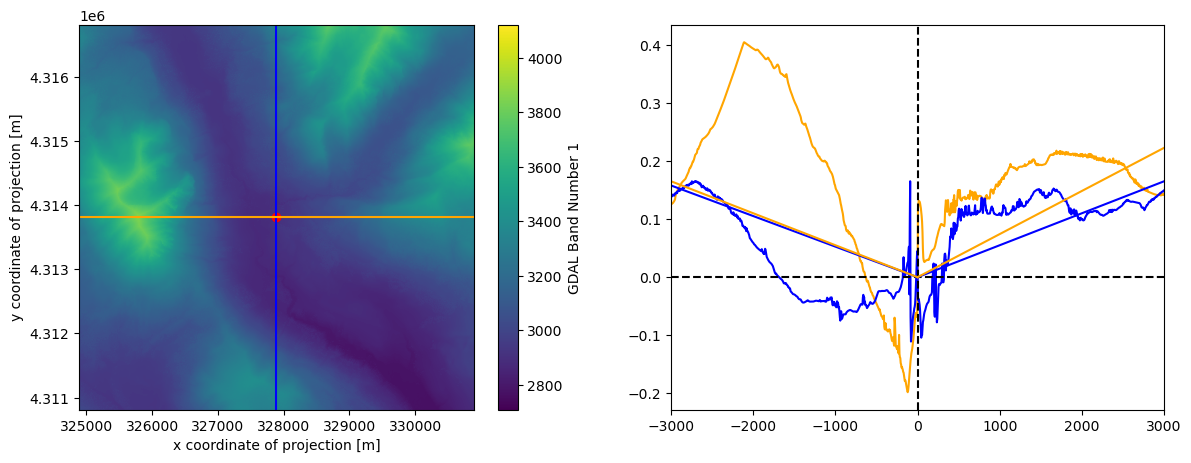

In [13]:
fig,axx=plt.subplots(1,2, figsize=(14,5))
ax = axx[0]
dem_main_coarsen.plot(ax=ax)# vmin=2700, vmax=3100, cmap="terrain")
#dem_main_coarsen.plot.contour(ax=ax, levels=[2890, 2895, 2900,2905, 2910, 2915, 2920,2930], colors='black', alpha=.2)
ax.set_ylim(yl-3000, yl+3000)
ax.set_xlim(xl-3000, xl+3000)
ax.axvline(xl, color='blue')
ax.axhline(yl, color='orange')
ax.scatter(xl, yl, color='red')

###  the next plot
ax2 = axx[1]
ax2.plot(dx, hangle_x.values[0,:], color='orange')
ax2.plot(dy, hangle_y.values[:,0], color='blue')
ax2.axvline(0, color='black', linestyle='--')
ax2.set_xlim(-3000,3000)
ax2.axhline(0, color='black', linestyle='--')



### plot the results of topocalc...
hacz_south = np.cos(np.radians(90 - ds.hangle.sel(x=xl, y=yl, method="nearest").sel(azimuth=0, method="nearest").values))
hacz_north = np.cos(np.radians(90 - ds.hangle.sel(x=xl, y=yl, method="nearest").sel(azimuth=180, method="nearest").values))

hacz_west = np.cos(np.radians(90 - ds.hangle.sel(x=xl, y=yl, method="nearest").sel(azimuth=270, method="nearest").values))
hacz_east = np.cos(np.radians(90 - ds.hangle.sel(x=xl, y=yl, method="nearest").sel(azimuth=90, method="nearest").values))

ax2.plot([-3000, 0], [hacz_south,0], color='blue')
ax2.plot([3000, 0],  [hacz_north,0], color='blue')

ax2.plot([-3000, 0], [hacz_west,0], color='orange')
ax2.plot([3000, 0],  [hacz_east,0], color='orange')



In [14]:
import math 
def calculate_solar_az(datetime_obj):
    observer = ephem.Observer()
    lat  = "38.980762"    # ERW
    lon = "-107.005017"  # ERW
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elevation = 2000
    observer.date = datetime_obj
    sun = ephem.Sun(observer)
    return sun.az

def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = "38.980762"    # ERW
    longitude = "-107.005017"  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.elevation = 2000
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith


def calculate_solar_ang(datetime_obj):
    observer = ephem.Observer()
    latitude  = "38.980762"    # ERW
    longitude = "-107.005017"  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.elevation = 2000
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    return solar_altitude

In [15]:
def convert_azimuth(azimuth):
    # Convert azimuth from the provided convention to standard convention
    azimuth_standard = azimuth # (180 - azimuth )# (90 - azimuth) % 360    
    return azimuth_standard#.where(azimuth_standard > 0, azimuth_standard + 180)

    # newaz = []
    # for az in azimuth_standard:
    #     if ((az < 270) and (az > 90)):
    #         newaz.append(az.values - 180)
    #     if ((az < 90) or (az > 270)):
    #         newaz.append(az.values + 180)



In [16]:
april1 = pd.DataFrame(index=pd.date_range(start="2021-04-01", end="2021-04-02", freq="10min"))
april1['az']   = april1.index.map(calculate_solar_az)
april1['cza']  = april1.index.map(calculate_solar_cos_zenith)
april1['sa']  = april1.index.map(calculate_solar_ang)
april1['dayminute'] = april1.index.hour * 60 + april1.index.minute
april1 = april1.where(april1.cza > 0).dropna()

In [17]:
jan1 = pd.DataFrame(index=pd.date_range(start="2021-01-01", end="2021-01-02", freq="10min"))
jan1['az']   = jan1.index.map(calculate_solar_az)
jan1['cza']  = jan1.index.map(calculate_solar_cos_zenith)
jan1['sa']  = jan1.index.map(calculate_solar_ang)
jan1['dayminute'] = jan1.index.hour * 60 + jan1.index.minute
jan1=jan1.where(jan1.cza > 0).dropna()

In [18]:
dec20 = pd.DataFrame(index=pd.date_range(start="2021-12-20", end="2021-12-21", freq="10min"))
dec20['az']   = dec20.index.map(calculate_solar_az)
dec20['cza']  = dec20.index.map(calculate_solar_cos_zenith)
dec20['sa']  = dec20.index.map(calculate_solar_ang)
dec20['dayminute'] = dec20.index.hour * 60 + dec20.index.minute
dec20=dec20.where(dec20.cza > 0).dropna()

In [19]:
jun20 = pd.DataFrame(index=pd.date_range(start="2021-06-20", end="2021-06-21", freq="10min"))
jun20['az']   = jun20.index.map(calculate_solar_az)
jun20['cza']  = jun20.index.map(calculate_solar_cos_zenith)
jun20['sa']  = jun20.index.map(calculate_solar_ang)
jun20['dayminute'] = jun20.index.hour * 60 + jun20.index.minute
jun20=jun20.where(jun20.cza > 0).dropna()

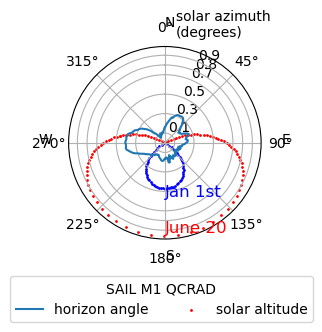

In [25]:
fig, ax = plt.subplots(figsize=(4, 2.5), subplot_kw={'projection': 'polar'})

xl2 = xl - 500 
yl2 = yl + 2000
data = np.cos(((90 - ds.sel(x=xl, y=yl, method="nearest").hangle)/180 * np.pi))

ax.plot(np.radians(convert_azimuth(data.azimuth)), data.values, label='horizon angle')
ax.set_ylim(0,.99)
ax.set_yticks([.1, .3, .5, .7, .8, .9])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.scatter(jun20.az, jun20.cza, s=1, color='red',  label='solar altitude')#
ax.scatter(jan1.az,  jan1.cza,  s=1, color='blue')#,  c=jan1.dayminute,   cmap="viridis")

ax.text(np.pi, .92, "June 20", fontsize=12,   color='red')
ax.text(np.pi, .55, "Jan 1st",   fontsize=12, color='blue')
#fig.colorbar(cb, ax=ax, label="dayminute")
#ax.text(np.pi/8, .9, "cza")
ax.text(.1, 1.1, "solar azimuth \n(degrees)")
fig.legend(title='SAIL M1 QCRAD', ncol=4, bbox_to_anchor=(.9, -.01))

ax.text(np.pi*0, 1.2, "N")
ax.text(np.pi/2, 1.2, "E")
ax.text(np.pi*1, 1.2, "S")
ax.text(3*np.pi/2, 1.3, "W")
plt.savefig("/Users/william/Documents/projects/cloud_radiative_forcing/paper/EastRiver-CRE2_2024/figures_supplemental/FigureX_horizon_angle.png", dpi=300)

/var/folders/xn/r3tq698x1vx8d2ctxvdzt6nr0000gn/T/ipykernel_49494/3513474430.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121, projection='polar')


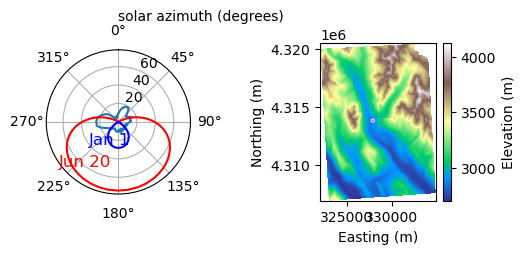

In [48]:
#fig, ax = plt.subplots(figsize=(4.5,4), subplot_kw={'projection': 'polar'})

fig, axx = plt.subplots(1, 2, figsize=(5, 2.5)) 

# Polar plot
ax = plt.subplot(121, projection='polar')




xl2 = xl - 500 
yl2 = yl + 2000
data = ds.sel(x=xl, y=yl, method="nearest").hangle

ax.plot(np.radians(convert_azimuth(data.azimuth)), data.values, label='terrain horizon angle')
#ax.set_ylim(0,.99)
#ax.set_yticks([.1, .3, .5, .7, .8, .9])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.plot(jun20.az,  np.rad2deg(jun20.sa), color='red', label='June20 solar altitude')#,  c=april1.dayminute, cmap="viridis")
ax.plot(jan1.az,   np.rad2deg(jan1.sa),  color='blue', label='Jan1 solar altitude')#,  c=jan1.dayminute,   cmap="viridis")

ax.text(180, 40, "Jan 1",   fontsize=12, color='blue')
ax.text(180, 80, "Jun 20", fontsize=12, color='red')
#fig.colorbar(cb, ax=ax, label="dayminute")
#ax.text(np.pi/8, .9, "cza")
ax.text(0, 110, "solar azimuth (degrees)", transform=ax.transData)

#fig.legend(loc='upper left')
plt.tight_layout()

#ax.text(np.pi*0, 1.2, "N")
#ax.text(np.pi/2, 1.2, "E")
#ax.text(np.pi*1, 1.2, "S")
#ax.text(3*np.pi/2, 1.3, "W")



dem_main_coarsen.plot(ax=axx[1], cbar_kwargs={"label":"Elevation (m)"}, cmap="terrain")
xl = 327889.75427288306
yl = 4313811.21370096

axx[1].set_ylabel("Northing (m)")
axx[1].set_xlabel("Easting (m)")
axx[1].scatter(xl, yl, facecolor='none', edgecolor='pink', s=5)
plt.subplots_adjust(wspace=.9)


plt.savefig("/Users/william/Documents/projects/cloud_radiative_forcing/paper/EastRiver-CRE2_2024/figures_supplemental/Supp_FigureX_horizon_angle.png", dpi=300)

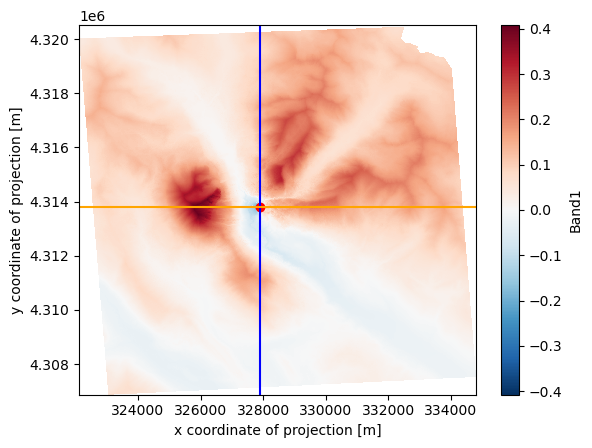

In [19]:
xl2 = xl #+ 3000 
yl2 = yl #- 3000

hgt_val = dem_main_coarsen.sel(x=xl2, y=yl2, method="nearest")


hgt_diff = (dem_main_coarsen - hgt_val)
distx, disty = np.meshgrid((dem_main_coarsen.x - hgt_val.x), (dem_main_coarsen.y - hgt_val.y))
disttot = np.sqrt(distx**2 + disty**2)
hangle_computed_by_me=np.sin(np.arctan2(hgt_diff,  disttot))
hangle_computed_by_me.plot()

plt.scatter(xl2, yl2, color='red')

plt.axvline(xl, color='blue')
plt.axhline(yl, color='orange')


In [20]:
def angle_from_point(ds, xl, yl):
    the_point = ds.sel(x=xl, y=yl, method="nearest")
    ix,iy =np.meshgrid((ds.x - the_point.x), (ds.y - the_point.y))
    data = xr.DataArray(np.arctan2(iy, ix), dims=["y", "x"], coords={"x":ds.x, "y":ds.y})
    datadeg = 90 - np.degrees(data)
    return datadeg.where(datadeg > 0, datadeg + 360)

In [21]:
ang_from_pt = angle_from_point(dem_main_coarsen, xl, yl)

In [22]:
disttot=xr.DataArray(disttot, dims=["y", "x"], coords={"x":ds.x, "y":ds.y})

In [23]:
def get_vector_from_angle(ds, disttot, ang_from_pt, ang=135):
    da=.05
    vec2d  = ds.where(ang_from_pt < ang+da).where(ang_from_pt > ang - da)
    ang2d  = ang_from_pt.where(ang_from_pt < ang+da).where(ang_from_pt > ang - da)
    dist2d = disttot.where(ang_from_pt < ang+da).where(ang_from_pt > ang - da)
    return vec2d,ang2d,dist2d

In [24]:
vec2d, ang2d, dist2d  = get_vector_from_angle(hangle_computed_by_me, disttot, ang_from_pt, ang=90)

In [25]:
max_horizon = []
for a in np.linspace(0,360,720):
    vec2d,ang2d,dist2d  = get_vector_from_angle(hangle_computed_by_me, disttot, ang_from_pt, ang=a)
    max_horizon.append(vec2d.max())


[Text(0.0, 0, 'N'),
 Text(1.5707963267948966, 0, 'E'),
 Text(3.141592653589793, 0, 'S'),
 Text(4.71238898038469, 0, 'W')]

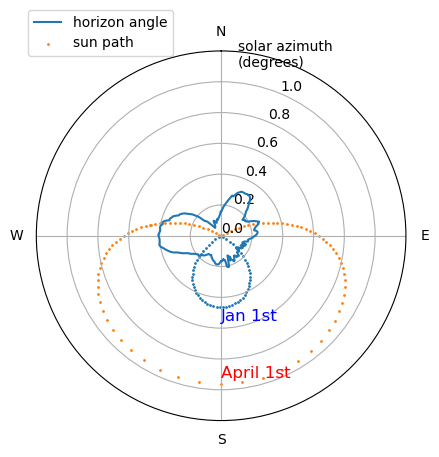

In [102]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

xl2 = xl - 500 
yl2 = yl + 2000
data = np.cos(((90 - ds.sel(x=xl, y=yl, method="nearest").hangle)/180 * np.pi))

ax.plot(np.radians(data.azimuth), data.values, label='horizon angle')
#ax.plot(np.radians(np.linspace(0,360,720)) , max_horizon, label='test')

ax.set_ylim(0,1.2)
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#ax.scatter(april1.az, april1.cza,  s=1)#,  c=april1.dayminute, cmap="viridis")
#ax.scatter(jan1.az,   jan1.cza,   s=1, label='sun path')#,  c=jan1.dayminute,   cmap="viridis")
ax.scatter(dec20.az,   dec20.cza,     s=1) #c=april1.dayminute, cmap="viridis")
ax.scatter(jun20.az,   jun20.cza,     s=1, label='sun path')#,  c=jan1.dayminute,   cmap="viridis")



ax.text(np.pi, .92, "April 1st", fontsize=12, color='red')
ax.text(np.pi, .55, "Jan 1st",   fontsize=12, color='blue')
#ax.text(np.pi/8, .9, "cza")
ax.text(.1, 1.1, "solar azimuth \n(degrees)")
fig.legend(loc='upper left', bbox_to_anchor=(0.2, 0.98))


# ax.text(np.pi*0, 1.2, "N")
# ax.text(np.pi/2, 1.2, "E")
# ax.text(np.pi*1, 1.2, "S")
# ax.text(3*np.pi/2, 1.3, "W")

ax.set_xticks(np.arange(0, np.pi*2, np.pi/2))
ax.set_xticklabels(["N", "E", "S", "W"])

In [43]:
jun20

,az,cza,dayminute


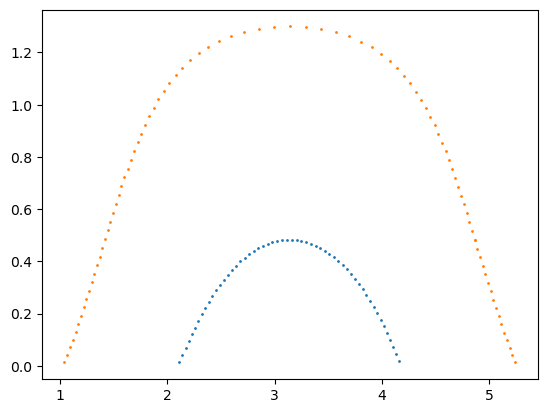

In [98]:
plt.scatter(dec20.az,   dec20.sa,  s=1)#,  c=april1.dayminute, cmap="viridis")
plt.scatter(jun20.az,   jun20.sa,   s=1, label='sun path')#,  c=jan1.dayminute,   cmap="viridis")


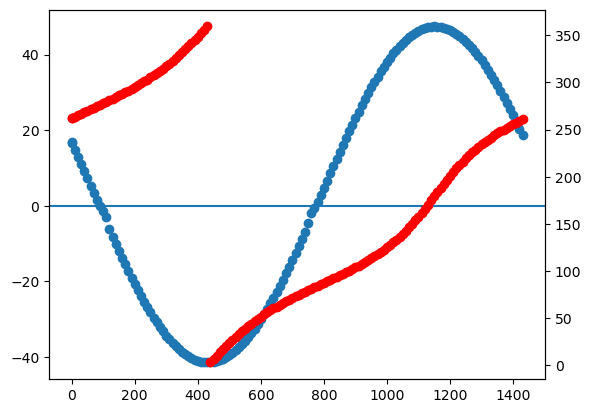

In [27]:
april1 = pd.DataFrame(index=pd.date_range(start="2021-04-01", end="2021-04-02", freq="10min"))
april1['az']   = april1.index.map(calculate_solar_az)   
april1['cza']  = april1.index.map(calculate_solar_cos_zenith)
april1['dayminute'] = april1.index.hour * 60 + april1.index.minute

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(april1.dayminute, np.degrees(april1.cza))
ax2.scatter(april1.dayminute, np.degrees(april1.az), color='red')
ax.axhline(0)

In [28]:
april1.where(april1.cza > 0).dropna()

,az,cza,dayminute
2021-04-01 00:00:00,4.573924,0.290000,0.0
2021-04-01 00:10:00,4.602610,0.257764,10.0
2021-04-01 00:20:00,4.630906,0.225161,20.0
2021-04-01 00:30:00,4.658885,0.192282,30.0
2021-04-01 00:40:00,4.686616,0.159211,40.0
...,...,...,...
2021-04-01 23:20:00,4.460216,0.417063,1400.0
2021-04-01 23:30:00,4.491198,0.386947,1410.0
2021-04-01 23:40:00,4.521466,0.356209,1420.0
2021-04-01 23:50:00,4.551109,0.324910,1430.0


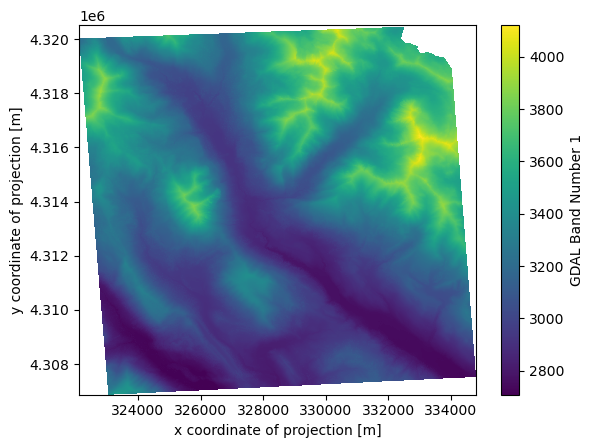

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Create some data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the data on the first axis
dem_main_coarsen.plot(ax=ax1)



# # Manually add a second axis in polar coordinates
# ax1.scatter(xl, yl)
# #ax2 = fig.add_subplot(111, polar=True)
# ax2 = fig.add_axes(ax1.get_position(), projection='polar', frame_on=False)

# ax2.set_theta_zero_location('N')
# ax2.set_theta_direction(-1)
# ax2.grid(visible=False)
# ax2.set_facecolor('none')

# # Plot some data on the second axis
# ax2.plot(np.radians(data.azimuth), data.values, label='cos(90-horizon angle)')
# ax2.set_ylim(0,1)

# # Set the title for the second axis
# ax2.set_title('Polar Plot')

# # Show the plot
plt.show()


In [30]:
ax1.transData.transform((xl, yl))

array([260.61767315, 240.84029175])